# DBSCAN Clustering
    -- density-based spatial clustering of applications with noise (DBSCAN)
    -- is a density-based algorithm that groups together points that are closely packed (high-density areas) and identifies points in low-density areas as noise or outliers.
    -- it does not require the number of clusters to be specified upfront

## Imports

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random_s = 101

## Load Data

In [37]:
# Load data

df = pd.read_csv("https://raw.githubusercontent.com/renatomaaliw3/public_files/master/Data%20Sets/wholesale.csv")
df.tail(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


## Normalize Data

In [38]:
# SCALED DATA

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]])

In [39]:
# Reconstruct to a dataframe

scaled_data = pd.DataFrame(df_scaled, columns = df.columns)
scaled_data.tail(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
437,1.448652,0.590668,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456
438,-0.690297,0.590668,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046
439,-0.690297,0.590668,-0.729307,-0.555924,-0.573227,-0.620094,-0.504888,-0.522869


## Select Features to Cluster

In [40]:
# Use Annual Income & Spending Score

reduced_df_scaled = scaled_data.drop(['Channel', 'Region'], axis = 1)
reduced_df_scaled.tail(3)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
437,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456
438,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046
439,-0.729307,-0.555924,-0.573227,-0.620094,-0.504888,-0.522869


## DBSCAN Parameters
    
      -- eps (epsilon): defines the maximum distance between two points for one to be considered as part of the neighborhood of the other
      -- min_samples: minimum number of points required to form a dense regions (core point).
      -- If a pont has a fewer than min_samples within eps, it is labeled as noise or an edge point

In [41]:
# NOTE:
# One of the best way to select the optimal eps is to use a k-distance graph, which helps to visualize
# the ideal eps value

# FOR eps:
# 1. Compute the distances between each point and its k-th nearest neighbor (typically k = min_samples)
# 2. Sort these distances and plot them. The point where the plot shows an "elbow", a significant
#    bend, is usually a good candidate fro eps.

# FOR min_samples:
# 1. A common rule of thumb for min_samples is to set it to be at least min_samples = 2 * dimensions.
# 2. Increase min_samples if you want fewer but larger clusters and decrease it if you expect many
#    smaller clusters.

# Silhouette Score (S-Score):
# After choosing eps and min_samples, you can evaluate the quality of your clustering using the S-Score,
# which measures how similar each point is to its own cluster compared to other clusters.
# This score ranges from -1 (bad blustering) to +1 (good clustering)

## K-Distance Graph

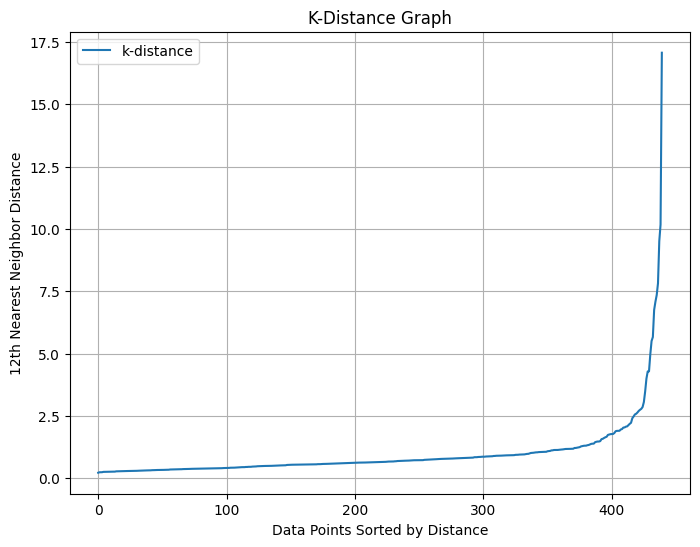

In [42]:
from sklearn.neighbors import NearestNeighbors

# Compute the K-Nearest Neighbors distances for k = min_samples
# min_samples = X (From 2 dimensions or two variables multiplied by 2)

min_samples = 12

neighbors = NearestNeighbors(n_neighbors = min_samples)
neighbors_fit = neighbors.fit(reduced_df_scaled)

distances, indices = neighbors_fit.kneighbors(reduced_df_scaled)

# Sort the distances (use the k-th nearest neighbor distance for each point)

k_distances = np.sort(distances[:,-1])

# Plot the k-distance graph

plt.figure(figsize = (8,6), facecolor = 'white')
plt.plot(k_distances, label = 'k-distance')
plt.title('K-Distance Graph')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel(f'{min_samples}th Nearest Neighbor Distance')
plt.grid(True)
# plt.axhline(y = 0.6, color = 'r', linestyle = '--', label = 'eps = 0.6')
plt.legend()
plt.show()

In [43]:
# Looking at the values

# Remember the number of nearest neighbor is set to 4, n_neighbors = min_samples = 4
# A matrix where each row contains the distances from a given data point to its k nearest neighbors

distances[:3,:]

array([[0.        , 0.46098501, 0.49746796, 0.58318528, 0.62085789,
        0.62588336, 0.64997706, 0.69480523, 0.71806015, 0.73809642,
        0.74749014, 0.77686706],
       [0.        , 0.34363739, 0.43048153, 0.43131993, 0.52926893,
        0.56999741, 0.59358274, 0.59695212, 0.62085789, 0.65241661,
        0.65604791, 0.67206554],
       [0.        , 1.14424502, 1.2507466 , 1.53289789, 1.59003936,
        1.60583871, 1.63859769, 1.70872402, 1.73016663, 1.74679765,
        1.81099243, 1.88535333]])

## Silhouette Scores (sklearn)

In [44]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Define range of potential eps values based on the k-distance plot

eps_values = np.linspace(0.2, 5, 15)

# Store S-Scores

s_scores = []

# Evaluate DBScan for each eps_values and calculate S-Score

for eps in eps_values:

  dbscan = DBSCAN(eps = eps, min_samples = min_samples)  # DBSCAN
  labels = dbscan.fit_predict(reduced_df_scaled)

  # Check if the clustering has more than 1 cluster to calculate S-Score
  if len(set(labels)) > 1:

    score = silhouette_score(reduced_df_scaled, labels)

  else:

    score = -1  # Invalid clustering scenario

  s_scores.append(score)

In [45]:
# Look at s_scores
s_scores

[-1,
 -0.0013677446475958345,
 0.48724281469437847,
 0.6077324820268872,
 0.645718583700062,
 0.7116795544767691,
 0.7422282374127741,
 0.7542161758333567,
 0.7542161758333567,
 0.7738898379253679,
 0.7852087185395047,
 0.7852087185395047,
 0.7852087185395047,
 0.7997875507977922,
 0.8049527819533608]

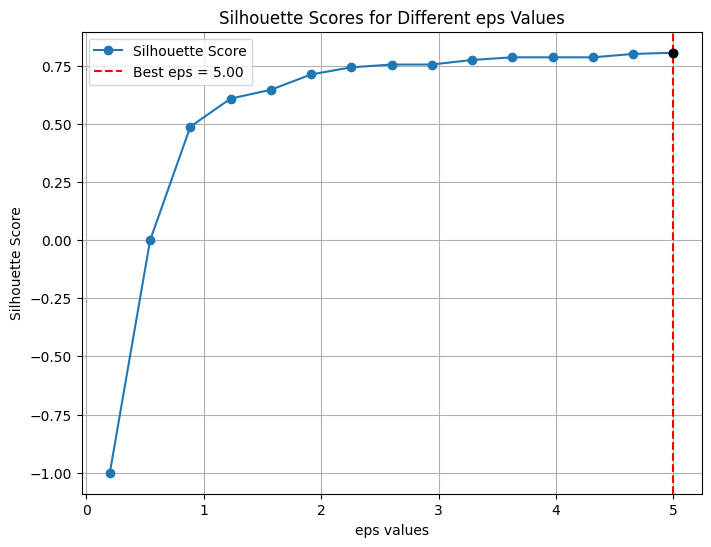

In [46]:
# Plot the S-Scores

# Plot the Silhouette Scores for different eps values

plt.figure(figsize=(8, 6))

# Plot silhouette scores for each eps value

plt.plot(eps_values, s_scores, marker='o', label='Silhouette Score')

# Add labels and title
plt.title('Silhouette Scores for Different eps Values')
plt.xlabel('eps values')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Highlight the best eps

best_eps_index = np.argmax(s_scores) # find the index of the best s_score
best_eps = eps_values[best_eps_index] # this will be 0.6
best_s_score = s_scores[best_eps_index] # this will be 0.421

plt.axvline(x = best_eps, color='r', linestyle='--', label = f'Best eps = {best_eps:.2f}')
plt.scatter(best_eps, best_s_score, color='black', zorder = 5)
plt.legend()
plt.show()

In [47]:
# Install yellowbrik
# !pip install yellowbrick
# NOTE: So far the yellobrick library support only KMeans clustering (n_clusters)

## Final DBSCAN Model

In [48]:
# Define DBSCAN model with eps= n and min_samples = n

final_model = DBSCAN(eps = 5, min_samples = 12)

# Fit the model to the scaled dataset

clusters = final_model.fit_predict(reduced_df_scaled)

# Add the cluster labels to the scaled DataFrame

reduced_df_scaled['Cluster'] = clusters
reduced_df_scaled.head(3)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339,0
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151,0
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293,0


## Visualized the Clusters

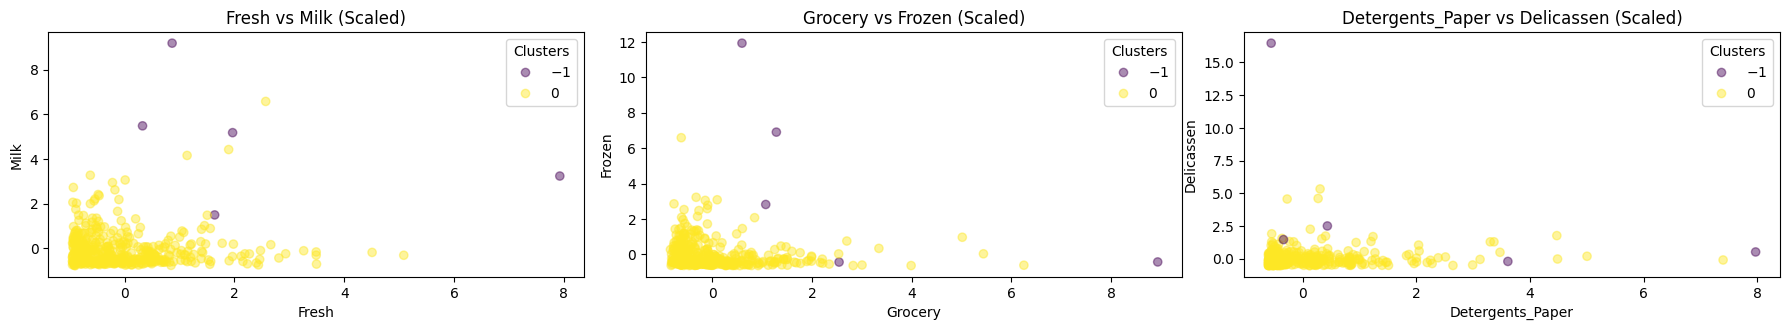

In [49]:
# Plotting the clusters

# Define pairs of features to visualize

feature_pairs = [

    ('Fresh', 'Milk'),
    ('Grocery', 'Frozen'),
    ('Detergents_Paper', 'Delicassen')

]

# Visualize the clusters in pairwise plots for the scaled data with individual legends for each plot

plt.figure(figsize=(18, 6))

for i, (feature_x, feature_y) in enumerate(feature_pairs, 1):

    plt.subplot(2, 3, i)

    scatter = plt.scatter(reduced_df_scaled[feature_x], reduced_df_scaled[feature_y],
                          c = reduced_df_scaled['Cluster'], marker = 'o', alpha = 0.45)

    plt.title(f'{feature_x} vs {feature_y} (Scaled)')

    plt.xlabel(feature_x)
    plt.ylabel(feature_y)

    # Add a legend to each subplot
    plt.legend(*scatter.legend_elements(), title = "Clusters") # place legend to all subplots

plt.tight_layout()
plt.show()

In [50]:
# NOTE:

# Outliers may be customers who spend significantly more or less than the typical customer in certain categories.

# Useful Business Insights

# High-value outliers:
# These could be customers who spend much more than typical clients, and they could represent VIP or premium customers.
# Understanding their behavior could help in personalizing services or marketing efforts for these customers.

# Low-value outliers:
# These could be customers who are infrequent buyers or have very targeted purchasing habits.
# This might indicate an opportunity to increase engagement with this group through targeted marketing campaigns.

# Niche Markets:
# Some outliers might represent niche customers who have very specialized needs or preferences (e.g., spending mostly on Detergents_Paper and ignoring other categories).
# This could suggest an opportunity to cater to specific market segments.

# Anomalous Behavior Detection:
# Identifying outliers helps detect anomalous purchasing behavior.
# For example, if a customer has an extreme purchasing spike, this could signal fraud or an error in transaction data.

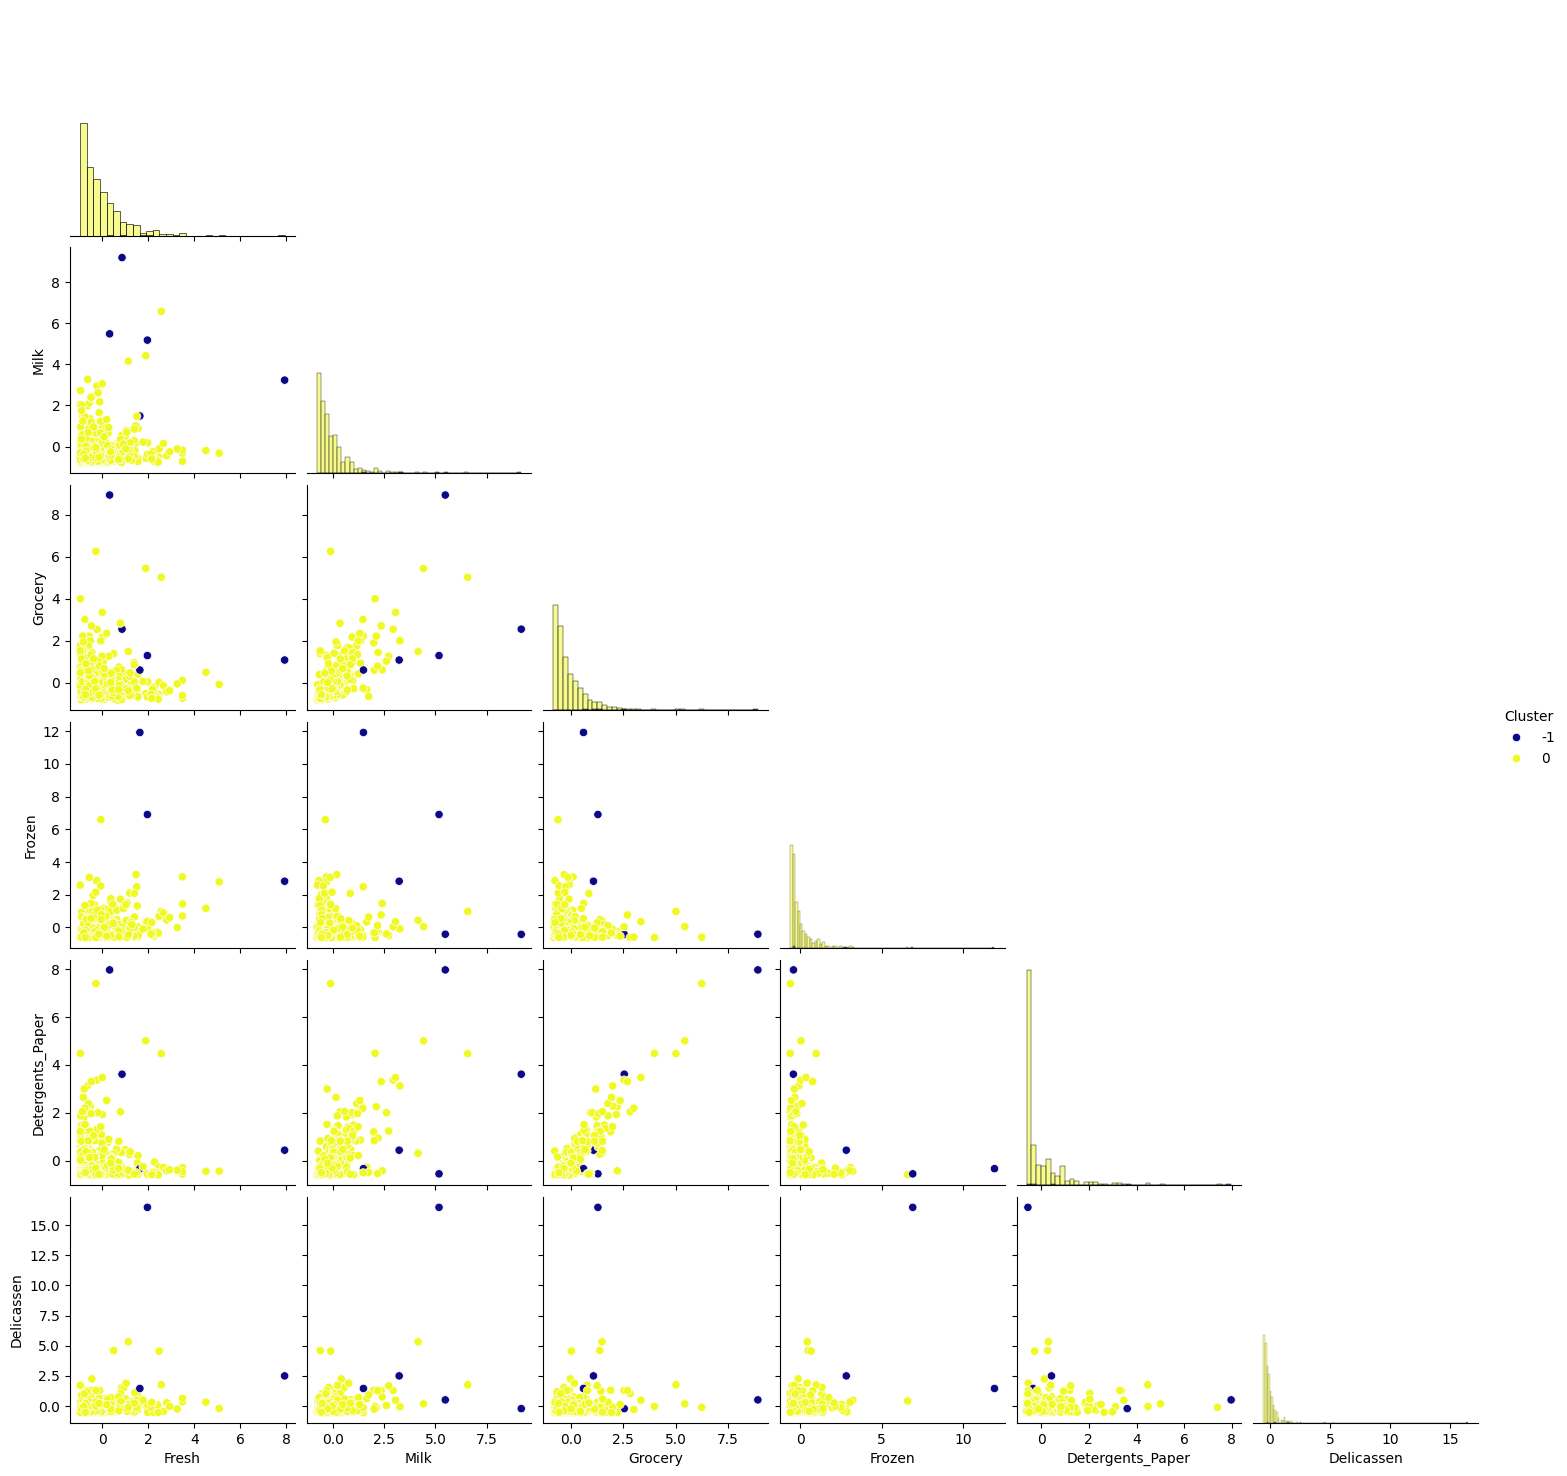

In [51]:
# Pairplot

sns.pairplot(reduced_df_scaled, hue = 'Cluster', palette = 'plasma', diag_kind = 'hist', corner = True)

In [52]:
# DBSCAN has flagged these as noise points (-1), indicating that their behaviors do not align with the majority of customers in the dataset.

In [53]:
# Outlier Counting

reduced_df_scaled[reduced_df_scaled['Cluster'] == -1]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
85,0.325870,5.480306,8.936528,-0.421915,7.967672,0.503791,-1
86,0.864778,9.183650,2.545492,-0.429958,3.609186,-0.220764,-1
181,7.927738,3.232607,1.074203,2.819681,0.433918,2.493923,-1
183,1.966817,5.175503,1.287217,6.900600,-0.554862,16.478447,-1
325,1.639894,1.490471,0.597820,11.919002,-0.337956,1.449867,-1
